In [1]:
import math
import os
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change this flag if you want to use wandb
use_wandb = False

if use_wandb:
    import wandb
    with open('wandb_key') as key_file:
        wandb_key = key_file.readline()
    wandb.login(key=wandb_key)

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True

In [2]:
def read_file(file_name):
    with open(file_name, 'r') as file:
        return list((map(lambda l: list(map(float, l.split(','))), file.readlines())))

In [3]:
def parse_params(file_name):
    params = re.findall(r'([a-zA-Z]+)(\d+(\.\d+)?)', file_name)
    return dict(map(lambda p: (p[0], float(p[1])), params))

In [4]:
def convert_x_train(x_train):
    x_train = np.array(x_train)

    t_count = len(np.unique(x_train[:, 0]))
    mu_count = len(np.unique(x_train[:, 1]))

    x_train = x_train[:t_count * mu_count]
    x_train = x_train.reshape((t_count, mu_count, -1))
    x_train = np.moveaxis(x_train, -1, 0)

    x_train = x_train[[3, 6, 10, 12, 13]]

    return x_train


def load_data(data_folder):
    x_train_list = []
    y_train_list = []
    for file_name in os.listdir(data_folder):
        params = parse_params(file_name)
        y_train_list.append([params['V']])
        x_train = convert_x_train(read_file(os.path.join(data_folder, file_name)))
        x_train_list.append(x_train)
    return torch.FloatTensor(np.array(x_train_list)).to(device), torch.FloatTensor(np.array(y_train_list)).to(device)

In [5]:
def get_train_dataloader(x_train, y_train, batch_size):
    train_dataloader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True,
                                                   num_workers=0)
    return train_dataloader

In [6]:
def get_test_dataloader(x_test, y_test, batch_size):
    test_dataloader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False,
                                                  num_workers=0)
    return test_dataloader

In [7]:
def split_x_train(x_train: torch.FloatTensor, y_train: torch.FloatTensor, test_size):
    # test_i = random.Random().sample(range(x_train.size()[0]), test_size)
    test_i = [random.randint(0, x_train.size()[0]) for _ in range(test_size)]
    # test_i = [68, 66, 67, 33, 59, 65, 35, 12, 32, 46, 3, 42, 13, 73, 37, 5]

    test_i.sort()
    print('test files', test_i)

    x_test = x_train.index_select(0, torch.IntTensor(test_i).to(device))
    y_test = y_train.index_select(0, torch.IntTensor(test_i).to(device))

    index = torch.BoolTensor(x_train.size()[0]).fill_(True)
    index[test_i] = False
    new_x_train = x_train[index]
    new_y_train = y_train[index]

    return new_x_train.detach(), new_y_train.detach(), x_test.detach(), y_test.detach()

In [8]:
def get_model(input_dim, output_dim):
    conv_part = nn.Sequential(
        nn.Sequential(
            nn.Conv2d(input_dim[0], 16, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)),
        nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)),
        nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)),
        nn.Flatten())

    x = torch.unsqueeze(torch.zeros(input_dim), 0)
    size = conv_part.forward(x).size()[1]
    print('Flatten size:', size)

    model = nn.Sequential(
        conv_part,
        nn.Linear(size, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, output_dim)
    )
    model.to(device)
    return model

In [9]:
def load_model(file, input_dim, output_dim):
    model = get_model(input_dim, output_dim)
    model.load_state_dict(torch.load(file)['model_state_dict'])
    return model

In [10]:
def train_epoch(model, loss, optimizer, dataloader, do_train):
    running_loss = 0.

    # Iterate over data.
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # forward and backward
        with torch.set_grad_enabled(do_train):
            preds = model(inputs)
            loss_value = loss(preds, targets)

            # backward + optimize only if in training phase
            if do_train:
                loss_value.backward()
                optimizer.step()

        # statistics
        running_loss += loss_value.item()

    epoch_loss = running_loss / len(dataloader)

    return epoch_loss


def train_model(model, loss, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, config):
    best_val_loss = math.inf
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()  # Set model to evaluate mode

            epoch_loss = train_epoch(model, loss, optimizer, dataloader, phase == 'train')

            if phase == 'train':
                scheduler.step()

            if phase == 'train':
                train_loss = epoch_loss
            else:
                val_loss = epoch_loss

            if phase == 'val' and best_val_loss > epoch_loss:
                print('new best val loss', epoch_loss)
                best_val_loss = epoch_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': config['exp_name']
                }, f'{config["exp_name"]}.pth')

        if use_wandb and phase == 'val':
            wandb.log({f'train loss': train_loss, f'val loss': val_loss})

    return model

In [11]:
data_folder = 'Data'

lr = 1e-3
epochs = 200
batch_size = 4
step_size = 20
gamma = 0.5

config = {
    "lr": lr,
    "epochs": epochs,
    "bs": batch_size,
    "sched": 'StepLR',
    "sched_ss": step_size,
    "sched_g": gamma,
    "optim": 'Adam',
}
important_keys = ['optim', 'bs']
config['exp_name'] = '_'.join(map(lambda key: f'{key}={config[key]}', important_keys))
model_file_name = config['exp_name']

if use_wandb:
    wandb.init(project='Chemistry', config=config)
    wandb.run.name = config['exp_name']

x_train, y_train = load_data(data_folder)
x_train, y_train, x_test, y_test = split_x_train(x_train, y_train, 16)

train_dataloader = get_train_dataloader(x_train, y_train, batch_size)
test_dataloader = get_test_dataloader(x_test, y_test, batch_size)

test files [0, 3, 8, 12, 15, 17, 26, 32, 48, 49, 55, 57, 60, 62, 63, 72]


In [12]:
model = get_model(x_train[0].size(), 1)

loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Flatten size: 512


In [13]:
model = train_model(model, loss_func, optimizer, scheduler, train_dataloader, test_dataloader, epochs, config)

new best val loss 0.10066678188741207
new best val loss 0.04207494668662548
new best val loss 0.015875879675149918
new best val loss 0.003935122862458229
new best val loss 0.0030028652399778366
new best val loss 0.001758817583322525
new best val loss 0.0014562532305717468
new best val loss 0.0013952609151601791
new best val loss 0.0012789741158485413
new best val loss 0.0012354832142591476
new best val loss 0.0010140985250473022
new best val loss 0.000982813537120819
new best val loss 0.0009822715073823929
new best val loss 0.0009709428995847702
new best val loss 0.0009537506848573685
new best val loss 0.000933084636926651
new best val loss 0.0009297598153352737
new best val loss 0.0009169820696115494


In [14]:
if use_wandb:
    wandb.finish()

In [15]:
best_model = load_model(f'{config["exp_name"]}.pth', x_train[0].size(), 1)

Flatten size: 512


In [16]:
y_test_result = best_model.forward(x_test).detach()
y_train_result = best_model.forward(x_train).detach()

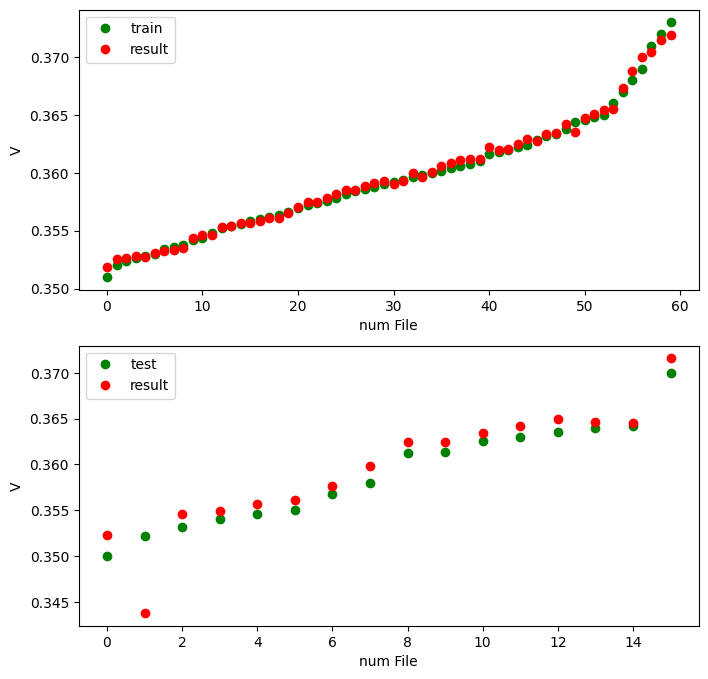

In [17]:
fig = plt.figure(figsize=(8, 8))

ax_train = fig.add_subplot(2, 1, 1)
ax_train.plot(y_train.cpu().numpy(), 'go', label='train')
ax_train.plot(y_train_result.cpu().numpy(), 'ro', label='result')
ax_train.set_ylabel('V')
ax_train.set_xlabel('num File')
ax_train.legend()

ax_test = fig.add_subplot(2, 1, 2)
ax_test.plot(y_test.cpu().numpy(), 'go', label='test')
ax_test.plot(y_test_result.cpu().numpy(), 'ro', label='result')
ax_test.set_ylabel('V')
ax_test.set_xlabel('num File')
ax_test.legend()

plt.show()

In [18]:
def mean_absolute_percentage_error_my(preds, targets):
    return ((preds - targets).abs() / targets).sum() / len(targets)

In [19]:
train_error = mean_absolute_percentage_error_my(y_train_result, y_train).item()
print('train error', train_error)
test_error = mean_absolute_percentage_error_my(y_test_result, y_test).item()
print('test error', test_error)

train error 0.0008291551494039595
test error 0.00457371398806572
